In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path = '../data/jena_climate_2009_2016.csv'
df = pd.read_csv(path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [3]:
#normalize the data
df.drop(['Date Time'], axis=1, inplace=True)
#min-max normalization
df = (df - df.min()) / (df.max() - df.min())
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,0.814939,0.248632,0.243662,0.334788,0.923033,0.037886,0.084272,0.004782,0.081679,0.082798,0.743213,0.997262,0.997830,0.423056
1,0.815430,0.242163,0.237241,0.326891,0.924182,0.036294,0.081003,0.004564,0.078843,0.079586,0.749349,0.997231,0.997805,0.378056
2,0.815037,0.240504,0.235594,0.326268,0.929925,0.035976,0.080639,0.004347,0.078276,0.079229,0.750666,0.997178,0.997718,0.476667
3,0.814840,0.243822,0.239052,0.331255,0.933372,0.036772,0.082819,0.004130,0.080545,0.081370,0.747523,0.997193,0.997705,0.550000
4,0.814840,0.244485,0.239546,0.331879,0.932223,0.036931,0.083182,0.004130,0.080545,0.081727,0.746954,0.997191,0.997718,0.595278


In [4]:
X = df.drop(['T (degC)'], axis=1).values
y = df['T (degC)'].values

X.shape, y.shape

((420551, 13), (420551,))

In [5]:
# 80% of the data is used for training
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [6]:
def sliding_windows(X, y, seq_length, forecast_horizon):
    #length of X is seq_length
    #length of y is seq_length + forecast_horizon
    Xs, ys = [], []
    for i in range(len(X) - seq_length - forecast_horizon + 1):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i:i+seq_length+forecast_horizon])
    return np.array(Xs), np.array(ys)

In [7]:
seq_length = 64
forecast_horizon = 10
X_train, y_train = sliding_windows(X_train, y_train, seq_length=seq_length, forecast_horizon=forecast_horizon)
X_test, y_test = sliding_windows(X_test, y_test, seq_length=seq_length, forecast_horizon=forecast_horizon)

In [8]:
#torch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [9]:
#datasets and dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
#model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
#model
input_size = X_train.shape[-1]
hidden_size = 128
num_layers = 3
output_size = forecast_horizon
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

In [13]:
#feed a sample through the model
for i, (X, y) in enumerate(train_loader):
    X = X.to(device)
    y = y.to(device)
    out = model(X)
    print(out.shape)
    break

torch.Size([64, 10])


In [14]:
#loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
for i, (X, y) in enumerate(train_loader):
    y = y[:, -forecast_horizon:]
    print(y.shape)
    break

torch.Size([64, 10])


In [16]:
#training
num_epochs = 100
model.train()
for epoch in range(num_epochs):
    for X, y in train_loader:
        X = X.to(device)
        y = y[:, -forecast_horizon:].to(device)
        out = model(X)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0001
Epoch [20/100], Loss: 0.0001
Epoch [30/100], Loss: 0.0001
Epoch [40/100], Loss: 0.0001
Epoch [50/100], Loss: 0.0001
Epoch [60/100], Loss: 0.0000
Epoch [70/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000


In [20]:
#testing
model.eval()
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        out = model(X)
        break

In [21]:
#plotting
y_pred = out.cpu().numpy()

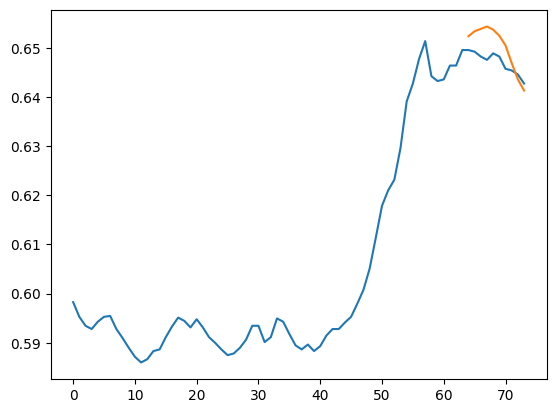

In [25]:
plt.plot(y[31].cpu().numpy(), label='actual')
plt.plot(range(seq_length, seq_length+len(y_pred[31])), y_pred[31], label='predicted')